# Method 8 - Best Ideas Low Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] < popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

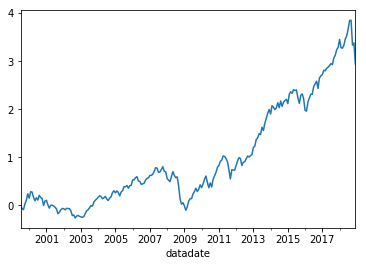

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.244509
2000-12-31   -0.122477
2001-12-31   -0.140599
2002-12-31   -0.175993
2003-12-31    0.468758
2004-12-31    0.150831
2005-12-31    0.084758
2006-12-31    0.109782
2007-12-31    0.081409
2008-12-31   -0.378441
2009-12-31    0.351729
2010-12-31    0.256266
2011-12-31   -0.033784
2012-12-31    0.186164
2013-12-31    0.455552
2014-12-31    0.070020
2015-12-31    0.003691
2016-12-31    0.148283
2017-12-31    0.159967
2018-12-31   -0.081264
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     738.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.35e-129
Time:                        06:34:55   Log-Likelihood:                 674.77
No. Observations:                 234   AIC:                            -1340.
Df Residuals:                     229   BIC:                            -1322.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.842      0.400      -0.001       0.003
mktrf          1.0734      0.026     42.070      0.000       1.023       1.124
me             0.3825      0.030     12.887      0.000       0.324       0.441
ia            -0.0341      0.045     -0.755      0.451      -0.123       0.055
roe            0.1825      0.039      4.727      0.000       0.106       0.259
==============================================================================
Omnibus:                       72.890   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.815
Skew:                           1.012   Prob(JB):                    6.53e-110
Kurtosis:                       9.890   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     434.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.13e-105
Time:                        06:34:55   Log-Likelihood:                 674.77
No. Observations:                 234   AIC:                            -1340.
Df Residuals:                     229   BIC:                            -1322.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.086      0.277      -0.001       0.002
mktrf          1.0734      0.042     25.705      0.000       0.992       1.155
me             0.3825      0.029     13.312      0.000       0.326       0.439
ia            -0.0341      0.061     -0.555      0.579      -0.154       0.086
roe            0.1825      0.053      3.457      0.001       0.079       0.286
==============================================================================
Omnibus:                       72.890   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.815
Skew:                           1.012   Prob(JB):                    6.53e-110
Kurtosis:                       9.890   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     451.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.33e-107
Time:                        06:34:55   Log-Likelihood:                 674.77
No. Observations:                 234   AIC:                            -1340.
Df Residuals:                     229   BIC:                            -1322.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.190      0.234      -0.001       0.002
mktrf          1.0734      0.044     24.256      0.000       0.987       1.160
me             0.3825      0.029     13.225      0.000       0.326       0.439
ia            -0.0341      0.055     -0.615      0.539      -0.143       0.075
roe            0.1825      0.053      3.445      0.001       0.079       0.286
==============================================================================
Omnibus:                       72.890   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.815
Skew:                           1.012   Prob(JB):                    6.53e-110
Kurtosis:                       9.890   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     502.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.85e-121
Time:                        06:34:55   Log-Likelihood:                 657.80
No. Observations:                 234   AIC:                            -1304.
Df Residuals:                     228   BIC:                            -1283.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.116      0.266      -0.001       0.003
mktrf          1.0478      0.028     38.032      0.000       0.993       1.102
smb            0.3946      0.036     10.855      0.000       0.323       0.466
hml           -0.0874      0.043     -2.038      0.043      -0.172      -0.003
rmw            0.1037      0.048      2.141      0.033       0.008       0.199
cma            0.0584      0.062      0.948      0.344      -0.063       0.180
==============================================================================
Omnibus:                       87.056   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              763.995
Skew:                           1.183   Prob(JB):                    1.26e-166
Kurtosis:                      11.530   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     472.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.79e-118
Time:                        06:34:55   Log-Likelihood:                 657.80
No. Observations:                 234   AIC:                            -1304.
Df Residuals:                     228   BIC:                            -1283.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.370      0.171      -0.000       0.003
mktrf          1.0478      0.036     29.236      0.000       0.978       1.118
smb            0.3946      0.056      7.017      0.000       0.284       0.505
hml           -0.0874      0.061     -1.434      0.152      -0.207       0.032
rmw            0.1037      0.070      1.479      0.139      -0.034       0.241
cma            0.0584      0.125      0.468      0.640      -0.186       0.303
==============================================================================
Omnibus:                       87.056   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              763.995
Skew:                           1.183   Prob(JB):                    1.26e-166
Kurtosis:                      11.530   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     420.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.80e-113
Time:                        06:34:55   Log-Likelihood:                 657.80
No. Observations:                 234   AIC:                            -1304.
Df Residuals:                     228   BIC:                            -1283.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.465      0.143      -0.000       0.003
mktrf          1.0478      0.039     26.965      0.000       0.972       1.124
smb            0.3946      0.060      6.528      0.000       0.276       0.513
hml           -0.0874      0.063     -1.396      0.163      -0.210       0.035
rmw            0.1037      0.074      1.410      0.158      -0.040       0.248
cma            0.0584      0.125      0.467      0.640      -0.187       0.303
==============================================================================
Omnibus:                       87.056   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              763.995
Skew:                           1.183   Prob(JB):                    1.26e-166
Kurtosis:                      11.530   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     752.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.04e-130
Time:                        06:34:55   Log-Likelihood:                 676.70
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.127      0.261      -0.001       0.003
mktrf          1.0866      0.023     46.639      0.000       1.041       1.133
smb            0.2904      0.029      9.985      0.000       0.233       0.348
hml            0.0737      0.029      2.550      0.011       0.017       0.131
umd            0.1399      0.019      7.382      0.000       0.103       0.177
==============================================================================
Omnibus:                       67.198   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.640
Skew:                           0.921   Prob(JB):                     3.79e-98
Kurtosis:                       9.529   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     728.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.81e-129
Time:                        06:34:55   Log-Likelihood:                 676.70
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.322      0.186      -0.000       0.003
mktrf          1.0866      0.038     28.413      0.000       1.012       1.162
smb            0.2904      0.054      5.410      0.000       0.185       0.396
hml            0.0737      0.043      1.730      0.084      -0.010       0.157
umd            0.1399      0.037      3.830      0.000       0.068       0.212
==============================================================================
Omnibus:                       67.198   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.640
Skew:                           0.921   Prob(JB):                     3.79e-98
Kurtosis:                       9.529   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     874.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.07e-137
Time:                        06:34:55   Log-Likelihood:                 676.70
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.346      0.178      -0.000       0.003
mktrf          1.0866      0.039     27.999      0.000       1.011       1.163
smb            0.2904      0.061      4.730      0.000       0.170       0.411
hml            0.0737      0.040      1.858      0.063      -0.004       0.151
umd            0.1399      0.033      4.196      0.000       0.075       0.205
==============================================================================
Omnibus:                       67.198   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.640
Skew:                           0.921   Prob(JB):                     3.79e-98
Kurtosis:                       9.529   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     305.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.96e-60
Time:                        06:34:55   Log-Likelihood:                 322.81
No. Observations:                 120   AIC:                            -635.6
Df Residuals:                     115   BIC:                            -621.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.536      0.593      -0.002       0.004
mktrf          1.1265      0.043     26.050      0.000       1.041       1.212
me             0.3870      0.043      9.062      0.000       0.302       0.472
ia            -0.0857      0.067     -1.282      0.202      -0.218       0.047
roe            0.2857      0.059      4.827      0.000       0.168       0.403
==============================================================================
Omnibus:                       32.303   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.653
Skew:                           0.912   Prob(JB):                     5.12e-23
Kurtosis:                       7.148   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     195.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.80e-50
Time:                        06:34:55   Log-Likelihood:                 322.81
No. Observations:                 120   AIC:                            -635.6
Df Residuals:                     115   BIC:                            -621.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.682      0.495      -0.002       0.003
mktrf          1.1265      0.069     16.249      0.000       0.991       1.262
me             0.3870      0.036     10.849      0.000       0.317       0.457
ia            -0.0857      0.081     -1.054      0.292      -0.245       0.074
roe            0.2857      0.067      4.241      0.000       0.154       0.418
==============================================================================
Omnibus:                       32.303   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.653
Skew:                           0.912   Prob(JB):                     5.12e-23
Kurtosis:                       7.148   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     214.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.73e-52
Time:                        06:34:56   Log-Likelihood:                 322.81
No. Observations:                 120   AIC:                            -635.6
Df Residuals:                     115   BIC:                            -621.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.735      0.462      -0.001       0.003
mktrf          1.1265      0.067     16.723      0.000       0.994       1.259
me             0.3870      0.035     11.124      0.000       0.319       0.455
ia            -0.0857      0.071     -1.200      0.230      -0.226       0.054
roe            0.2857      0.054      5.248      0.000       0.179       0.392
==============================================================================
Omnibus:                       32.303   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.653
Skew:                           0.912   Prob(JB):                     5.12e-23
Kurtosis:                       7.148   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     186.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.07e-53
Time:                        06:34:56   Log-Likelihood:                 308.55
No. Observations:                 120   AIC:                            -605.1
Df Residuals:                     114   BIC:                            -588.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.074      0.285      -0.002       0.006
mktrf          1.0912      0.052     21.155      0.000       0.989       1.193
smb            0.3990      0.058      6.830      0.000       0.283       0.515
hml           -0.1600      0.072     -2.235      0.027      -0.302      -0.018
rmw            0.1928      0.084      2.284      0.024       0.026       0.360
cma            0.0862      0.092      0.932      0.353      -0.097       0.269
==============================================================================
Omnibus:                       36.024   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.454
Skew:                           0.978   Prob(JB):                     2.85e-29
Kurtosis:                       7.740   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     227.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.46e-57
Time:                        06:34:56   Log-Likelihood:                 308.55
No. Observations:                 120   AIC:                            -605.1
Df Residuals:                     114   BIC:                            -588.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.343      0.179      -0.001       0.005
mktrf          1.0912      0.059     18.459      0.000       0.975       1.207
smb            0.3990      0.080      4.969      0.000       0.242       0.556
hml           -0.1600      0.082     -1.943      0.052      -0.321       0.001
rmw            0.1928      0.104      1.846      0.065      -0.012       0.397
cma            0.0862      0.166      0.518      0.605      -0.240       0.413
==============================================================================
Omnibus:                       36.024   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.454
Skew:                           0.978   Prob(JB):                     2.85e-29
Kurtosis:                       7.740   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     211.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.84e-56
Time:                        06:34:56   Log-Likelihood:                 308.55
No. Observations:                 120   AIC:                            -605.1
Df Residuals:                     114   BIC:                            -588.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.404      0.160      -0.001       0.005
mktrf          1.0912      0.061     17.950      0.000       0.972       1.210
smb            0.3990      0.084      4.733      0.000       0.234       0.564
hml           -0.1600      0.087     -1.840      0.066      -0.330       0.010
rmw            0.1928      0.110      1.755      0.079      -0.023       0.408
cma            0.0862      0.170      0.508      0.611      -0.246       0.419
==============================================================================
Omnibus:                       36.024   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.454
Skew:                           0.978   Prob(JB):                     2.85e-29
Kurtosis:                       7.740   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     302.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.22e-60
Time:                        06:34:56   Log-Likelihood:                 322.22
No. Observations:                 120   AIC:                            -634.4
Df Residuals:                     115   BIC:                            -620.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.835      0.069      -0.000       0.006
mktrf          1.1316      0.038     29.557      0.000       1.056       1.207
smb            0.2288      0.044      5.249      0.000       0.142       0.315
hml            0.0541      0.044      1.240      0.218      -0.032       0.141
umd            0.1719      0.027      6.388      0.000       0.119       0.225
==============================================================================
Omnibus:                       19.534   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.574
Skew:                           0.544   Prob(JB):                     6.32e-12
Kurtosis:                       6.022   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     334.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.61e-62
Time:                        06:34:56   Log-Likelihood:                 322.22
No. Observations:                 120   AIC:                            -634.4
Df Residuals:                     115   BIC:                            -620.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.359      0.018       0.000       0.005
mktrf          1.1316      0.052     21.616      0.000       1.029       1.234
smb            0.2288      0.061      3.762      0.000       0.110       0.348
hml            0.0541      0.054      0.996      0.319      -0.052       0.161
umd            0.1719      0.045      3.797      0.000       0.083       0.261
==============================================================================
Omnibus:                       19.534   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.574
Skew:                           0.544   Prob(JB):                     6.32e-12
Kurtosis:                       6.022   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     439.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.13e-68
Time:                        06:34:56   Log-Likelihood:                 322.22
No. Observations:                 120   AIC:                            -634.4
Df Residuals:                     115   BIC:                            -620.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.460      0.014       0.001       0.005
mktrf          1.1316      0.046     24.466      0.000       1.041       1.222
smb            0.2288      0.065      3.534      0.000       0.102       0.356
hml            0.0541      0.050      1.090      0.276      -0.043       0.151
umd            0.1719      0.038      4.577      0.000       0.098       0.246
==============================================================================
Omnibus:                       19.534   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.574
Skew:                           0.544   Prob(JB):                     6.32e-12
Kurtosis:                       6.022   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     741.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.82e-78
Time:                        06:34:56   Log-Likelihood:                 386.21
No. Observations:                 114   AIC:                            -762.4
Df Residuals:                     109   BIC:                            -748.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.637      0.104      -0.000       0.003
mktrf          1.0157      0.025     41.325      0.000       0.967       1.064
me             0.3928      0.038     10.352      0.000       0.318       0.468
ia             0.0257      0.053      0.489      0.626      -0.079       0.130
roe           -0.0313      0.046     -0.676      0.500      -0.123       0.060
==============================================================================
Omnibus:                        0.843   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.827
Skew:                           0.201   Prob(JB):                        0.661
Kurtosis:                       2.887   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1011.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.69e-85
Time:                        06:34:56   Log-Likelihood:                 386.21
No. Observations:                 114   AIC:                            -762.4
Df Residuals:                     109   BIC:                            -748.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.957      0.050   -1.82e-06       0.003
mktrf          1.0157      0.023     44.694      0.000       0.971       1.060
me             0.3928      0.045      8.707      0.000       0.304       0.481
ia             0.0257      0.046      0.553      0.580      -0.065       0.117
roe           -0.0313      0.051     -0.613      0.540      -0.131       0.069
==============================================================================
Omnibus:                        0.843   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.827
Skew:                           0.201   Prob(JB):                        0.661
Kurtosis:                       2.887   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1007.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.59e-85
Time:                        06:34:56   Log-Likelihood:                 386.21
No. Observations:                 114   AIC:                            -762.4
Df Residuals:                     109   BIC:                            -748.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.308      0.021       0.000       0.003
mktrf          1.0157      0.025     40.456      0.000       0.966       1.065
me             0.3928      0.051      7.709      0.000       0.293       0.493
ia             0.0257      0.045      0.566      0.571      -0.063       0.115
roe           -0.0313      0.039     -0.808      0.419      -0.107       0.045
==============================================================================
Omnibus:                        0.843   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.827
Skew:                           0.201   Prob(JB):                        0.661
Kurtosis:                       2.887   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     661.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.97e-79
Time:                        06:34:56   Log-Likelihood:                 392.71
No. Observations:                 114   AIC:                            -773.4
Df Residuals:                     108   BIC:                            -757.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.501      0.617      -0.001       0.002
mktrf          1.0228      0.022     45.984      0.000       0.979       1.067
smb            0.3946      0.036     10.928      0.000       0.323       0.466
hml           -0.0576      0.046     -1.250      0.214      -0.149       0.034
rmw           -0.0622      0.056     -1.103      0.272      -0.174       0.050
cma            0.0549      0.072      0.768      0.444      -0.087       0.197
==============================================================================
Omnibus:                        0.435   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.584
Skew:                           0.116   Prob(JB):                        0.747
Kurtosis:                       2.737   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     440.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.30e-70
Time:                        06:34:56   Log-Likelihood:                 392.71
No. Observations:                 114   AIC:                            -773.4
Df Residuals:                     108   BIC:                            -757.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.539      0.590      -0.001       0.002
mktrf          1.0228      0.028     37.183      0.000       0.969       1.077
smb            0.3946      0.044      9.052      0.000       0.309       0.480
hml           -0.0576      0.043     -1.350      0.177      -0.141       0.026
rmw           -0.0622      0.055     -1.135      0.256      -0.170       0.045
cma            0.0549      0.058      0.945      0.344      -0.059       0.169
==============================================================================
Omnibus:                        0.435   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.584
Skew:                           0.116   Prob(JB):                        0.747
Kurtosis:                       2.737   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     400.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.32e-68
Time:                        06:34:56   Log-Likelihood:                 392.71
No. Observations:                 114   AIC:                            -773.4
Df Residuals:                     108   BIC:                            -757.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.620      0.535      -0.001       0.002
mktrf          1.0228      0.032     31.736      0.000       0.960       1.086
smb            0.3946      0.049      8.041      0.000       0.298       0.491
hml           -0.0576      0.036     -1.579      0.114      -0.129       0.014
rmw           -0.0622      0.056     -1.101      0.271      -0.173       0.049
cma            0.0549      0.051      1.067      0.286      -0.046       0.156
==============================================================================
Omnibus:                        0.435   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.584
Skew:                           0.116   Prob(JB):                        0.747
Kurtosis:                       2.737   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     853.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.85e-81
Time:                        06:34:56   Log-Likelihood:                 393.99
No. Observations:                 114   AIC:                            -778.0
Df Residuals:                     109   BIC:                            -764.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.137      0.892      -0.001       0.002
mktrf          1.0348      0.022     47.564      0.000       0.992       1.078
smb            0.4064      0.034     11.979      0.000       0.339       0.474
hml            0.0413      0.035      1.183      0.239      -0.028       0.111
umd            0.0513      0.026      1.947      0.054      -0.001       0.104
==============================================================================
Omnibus:                        0.476   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.788   Jarque-Bera (JB):                0.609
Skew:                           0.133   Prob(JB):                        0.737
Kurtosis:                       2.761   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     577.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.38e-72
Time:                        06:34:56   Log-Likelihood:                 393.99
No. Observations:                 114   AIC:                            -778.0
Df Residuals:                     109   BIC:                            -764.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.139      0.890      -0.001       0.002
mktrf          1.0348      0.026     39.224      0.000       0.983       1.086
smb            0.4064      0.034     12.037      0.000       0.340       0.473
hml            0.0413      0.033      1.251      0.211      -0.023       0.106
umd            0.0513      0.023      2.249      0.025       0.007       0.096
==============================================================================
Omnibus:                        0.476   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.788   Jarque-Bera (JB):                0.609
Skew:                           0.133   Prob(JB):                        0.737
Kurtosis:                       2.761   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     429.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.73e-66
Time:                        06:34:56   Log-Likelihood:                 393.99
No. Observations:                 114   AIC:                            -778.0
Df Residuals:                     109   BIC:                            -764.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.163      0.871      -0.001       0.001
mktrf          1.0348      0.031     33.479      0.000       0.974       1.095
smb            0.4064      0.036     11.282      0.000       0.336       0.477
hml            0.0413      0.030      1.359      0.174      -0.018       0.101
umd            0.0513      0.022      2.359      0.018       0.009       0.094
==============================================================================
Omnibus:                        0.476   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.788   Jarque-Bera (JB):                0.609
Skew:                           0.133   Prob(JB):                        0.737
Kurtosis:                       2.761   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""